<a href="https://colab.research.google.com/github/Gru97/DeepLearningCourse/blob/main/session11_exercise_rnn_xrp_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install yfinance
!pip install pytorch_lightning
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 43.0 MB/s eta 0:00:00


In [43]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import matplotlib.pyplot as plt


In [112]:
def fetch_xrp_data_yfinance():
    # Fetch XRP data from Yahoo Finance
    ticker = "XRP-USD"  # XRP in USD
    xrp_data = yf.download(ticker, start="2016-01-01", end="2025-1-25", interval="1d")

    # Save data to CSV
    xrp_data.to_csv("xrp_yahoo_data.csv")
    print("XRP data saved to 'xrp_yahoo_data.csv'!")

    return xrp_data

# Call the function
xrp_data = fetch_xrp_data_yfinance()
print(xrp_data.head())

[*********************100%***********************]  1 of 1 completed


XRP data saved to 'xrp_yahoo_data.csv'!
Price          Close      High       Low      Open     Volume
Ticker       XRP-USD   XRP-USD   XRP-USD   XRP-USD    XRP-USD
Date                                                         
2017-11-09  0.217488  0.221791  0.214866  0.217911  147916992
2017-11-10  0.206483  0.219068  0.205260  0.218256  141032992
2017-11-11  0.210430  0.214456  0.205459  0.205948  134503008
2017-11-12  0.197339  0.210214  0.195389  0.210214  251175008
2017-11-13  0.203442  0.204081  0.197456  0.197472  132567000


In [113]:
data = pd.read_csv('/content/xrp_yahoo_data.csv', skiprows=3)
data.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,Close,High,Low,Open,Volume
0,2017-11-10,0.206483,0.219068,0.205260,0.218256,141032992
1,2017-11-11,0.210430,0.214456,0.205459,0.205948,134503008
2,2017-11-12,0.197339,0.210214,0.195389,0.210214,251175008
3,2017-11-13,0.203442,0.204081,0.197456,0.197472,132567000
4,2017-11-14,0.209825,0.213693,0.203679,0.203679,127361000


In [114]:
#data = data.dropna()
data = data.set_index('Date')
data =data[[ 'Close', 'Open', 'Volume']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert back to DataFrame for convenience
scaled_data = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)
scaled_data.head(), scaled_data.shape, scaled_data.columns

import joblib
joblib.dump(scaler, 'minmax_scaler.pkl')  # Save to a file

['minmax_scaler.pkl']

In [154]:
def create_sequences(data, seq_length, pred_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length - pred_length):  #1117-10-1
        x = data.iloc[i:i + seq_length].values  # Past `seq_length` days
        y = data.iloc[i + seq_length:i + seq_length + pred_length]['Close'].values  # Next `pred_length` days
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 15  # Use past 10 days to predict
pred_length = 1  # Predict the next day
input, target = create_sequences(scaled_data, seq_length, pred_length)
input.shape, target.shape

((2617, 15, 3), (2617, 1))

In [155]:
test_size = 30  # Reserve the last 30 days for testing
x_train, y_train = input[:-test_size], target[:-test_size]
x_test, y_test = input[-test_size:], target[-test_size:]

# Step 3: Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [157]:
from torch.utils.data import DataLoader, TensorDataset

train_data= TensorDataset(x_train_tensor, y_train_tensor)
test_data=TensorDataset(x_test_tensor, y_test_tensor)

train_loader= DataLoader(train_data, batch_size=16, shuffle=True)
test_loader= DataLoader(test_data, batch_size=16)

In [158]:
def r2_score(y_true, y_pred):
    # Calculate the total sum of squares (variance of the actual values)
    total_variance = torch.sum((y_true - torch.mean(y_true))**2)

    # Calculate the residual sum of squares (variance between predicted and actual values)
    residual_variance = torch.sum((y_true - y_pred)**2)

    # Calculate R² score
    r2 = 1 - (residual_variance / total_variance)
    return r2

In [159]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

class PredictionModel(pl.LightningModule):
    def __init__(self, n_features, hidden_dim, n_outputs, learning_rate=0.01):
      super(PredictionModel, self).__init__()
      self.hidden_dim=hidden_dim
      self.n_features= n_features
      self.n_outputs= n_outputs
      self.learning_rate=learning_rate
      self.rnn = torch.nn.LSTM(input_size=n_features, hidden_size=hidden_dim, batch_first=True)  #(batch, seq_length, features)
      self.fc = torch.nn.Linear(hidden_dim, n_outputs)
      self.test_step_outputs = []  # List to store test step outputs

    def forward(self, x):
      rnn_out, _ = self.rnn(x) #rnn_out : (batch_size, seq_length, hidden_dim)
      final_hidden_state = rnn_out[:, -1, :]  #shape: (10,1)?
      output = self.fc(final_hidden_state)
      return output

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)  # Forward pass
        loss = torch.nn.functional.mse_loss(y_hat, y)
        self.log("train_loss", loss)

        r2 = r2_score(y, y_hat)
        self.log('train_r2', r2)

        return loss

    def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        # Calculate R² score
        r2 = r2_score(y, y_hat)

        # Log the test loss and R² score
        loss = torch.nn.MSELoss()(y_hat, y)
        self.log('test_loss', loss)
        self.log('test_r2', r2)

        self.test_step_outputs.append({'y_true': y, 'y_pred': y_hat})

        # Return predictions and actual values for further analysis
        return {'y_true': y, 'y_pred': y_hat}

    def on_test_epoch_end(self):
        # Concatenate all predictions and actual values
        y_true = torch.cat([x['y_true'] for x in self.test_step_outputs])
        y_pred = torch.cat([x['y_pred'] for x in self.test_step_outputs])

        # Store them as attributes for later use
        self.test_y_true = y_true
        self.test_y_pred = y_pred

        # Clear the outputs list for the next test run
        self.test_step_outputs.clear()

In [160]:
from pytorch_lightning import Trainer

model = PredictionModel(n_features=3, hidden_dim=16, n_outputs=1)
trainer = Trainer(max_epochs=100)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [161]:
trainer.fit(model, train_loader)

INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params | Mode 
----------------------------------------
0 | rnn  | LSTM   | 1.3 K  | train
1 | fc   | Linear | 17     | train
----------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.005     Total estimated model params size (MB)
2         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [163]:
trainer.test(model, test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.0025751313660293818   │
│          test_r2          │    0.4804254472255707     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.0025751313660293818, 'test_r2': 0.4804254472255707}]

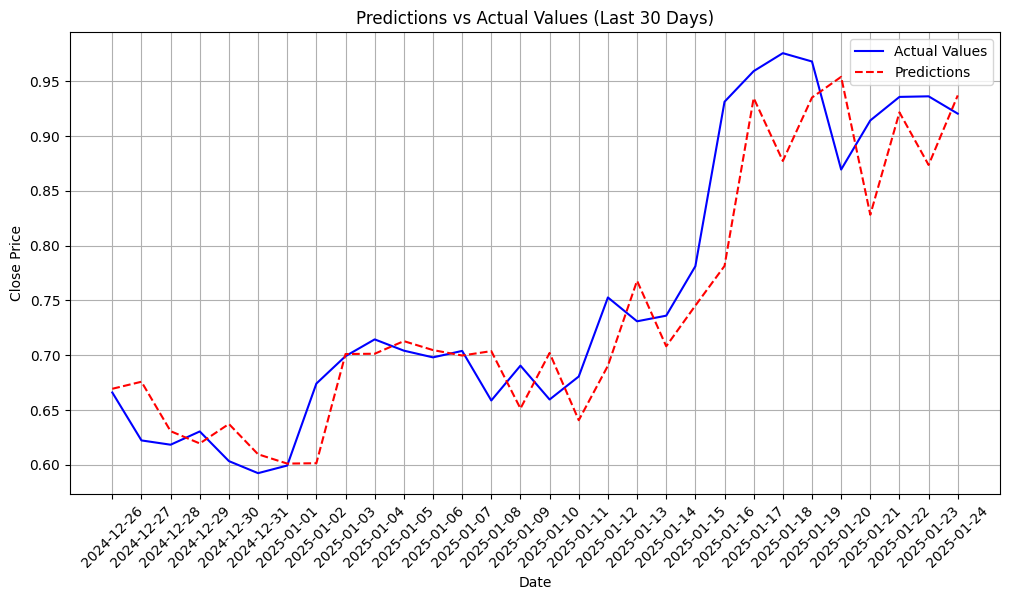

DatetimeIndex(['2024-12-26', '2024-12-27', '2024-12-28', '2024-12-29',
               '2024-12-30', '2024-12-31', '2025-01-01', '2025-01-02',
               '2025-01-03', '2025-01-04', '2025-01-05', '2025-01-06',
               '2025-01-07', '2025-01-08', '2025-01-09', '2025-01-10',
               '2025-01-11', '2025-01-12', '2025-01-13', '2025-01-14',
               '2025-01-15', '2025-01-16', '2025-01-17', '2025-01-18',
               '2025-01-19', '2025-01-20', '2025-01-21', '2025-01-22',
               '2025-01-23', '2025-01-24'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [164]:
test_data = scaled_data.iloc[-30:]  # Extract the last 30 days of data
test_dates = scaled_data.index[-30:]  # Dates for the last 30 days

plt.figure(figsize=(12, 6))
plt.plot(test_dates, model.test_y_true.cpu().numpy(), label='Actual Values', color='blue')
plt.plot(test_dates, model.test_y_pred.cpu().detach().numpy(), label='Predictions', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.xticks(test_dates, rotation=45)  # Rotate dates for better readability
plt.title('Predictions vs Actual Values (Last 30 Days)')
plt.legend()
plt.grid()
plt.show()

test_dates

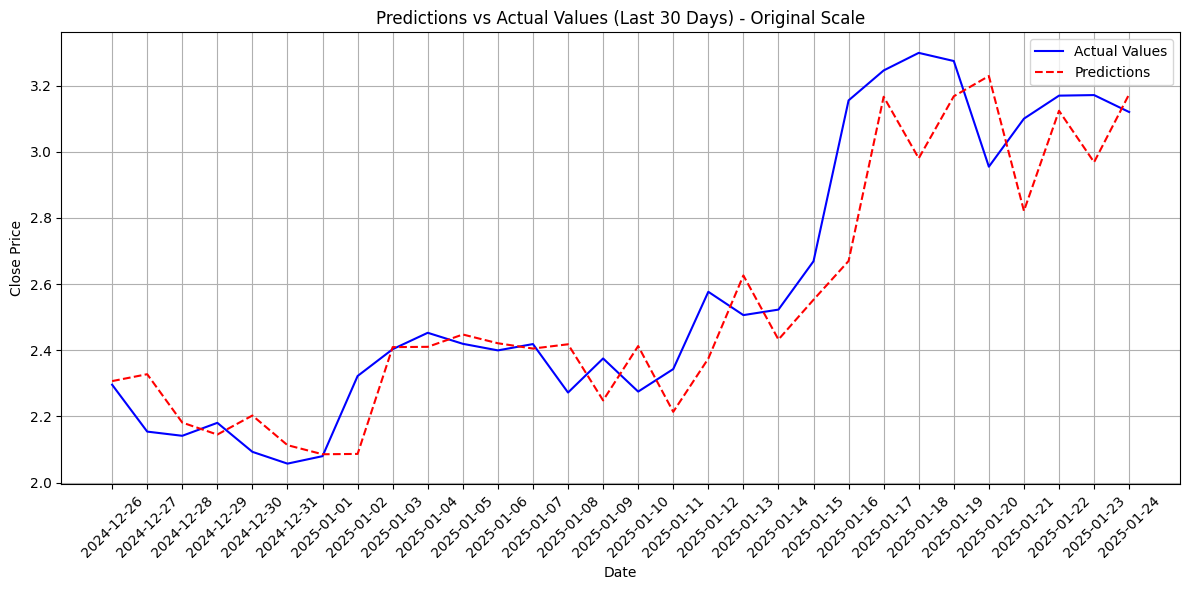

In [165]:
scaler = joblib.load('minmax_scaler.pkl')

# Assuming your scaler was fitted on 3 features (e.g., ['Close', 'High', 'Low'])
num_features = 3

# Reshape y_true and y_pred to (n_samples, 1)
y_true_scaled = model.test_y_true.cpu().numpy().reshape(-1, 1)
y_pred_scaled = model.test_y_pred.cpu().detach().numpy().reshape(-1, 1)

# Pad with zeros for the other features
y_true_padded = np.zeros((len(y_true_scaled), num_features))
y_pred_padded = np.zeros((len(y_pred_scaled), num_features))

# Replace the first column with the scaled 'Close' values
y_true_padded[:, 0] = y_true_scaled.flatten()
y_pred_padded[:, 0] = y_pred_scaled.flatten()

# Inverse transform the padded data
y_true_original = scaler.inverse_transform(y_true_padded)[:, 0]  # Extract the first column ('Close')
y_pred_original = scaler.inverse_transform(y_pred_padded)[:, 0]  # Extract the first column ('Close')

# Plot predictions vs actual values with dates (original scale)
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_true_original, label='Actual Values', color='blue')
plt.plot(test_dates, y_pred_original, label='Predictions', color='red', linestyle='--')

# Set x-axis to show all 30 dates
plt.xticks(test_dates, rotation=45)  # Rotate dates for better readability
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predictions vs Actual Values (Last 30 Days) - Original Scale')
plt.legend()
plt.grid()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs/